In [845]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.src.utils import pad_sequences
from sklearn.model_selection import train_test_split

# Get data
Pandas is used to get the data from the project directory.
The data is a .csv file, that has been created by book texts and prepared to be listed in the file word-by-word.

In [846]:
df = pd.read_csv('dataset.csv')
df = df.sample(frac=1.0, random_state=42)
df.head()

,Word,Language
24443,doors and were in the car speeding toward the,English
13609,questi li ha in custodia un,Italian
43979,jeg henter mine udtryk fra mine daglige,Danish
33611,εσύ θα τα βρεις με την έστερ,Greek
44954,nå gør han det? sagde ravn gnaven,Danish


# Prepare data
Divide the data into X and y. X is input and y is the desired output.
One-Hot Encode it, so the language is categorical. This is done with Pandas.

In [847]:
# Getting X - the input values
X = df.iloc[:, :-1]
X.loc[:, 'Word'] = X['Word'].astype(str)
tokenizer = Tokenizer(char_level=True) # Used for turning the words into numbers
tokenizer.fit_on_texts(X['Word'].tolist()) # Giving Tokenizer the data it needs to learn how to encode the words
X_sequences = tokenizer.texts_to_sequences(X['Word'].tolist()) # Now the words are encoded into sequences
input_dim = max(len(seq) for seq in X_sequences)
X = pad_sequences(
    X_sequences, 
    maxlen=input_dim, 
    padding='post'
) # Making all input values be of same length
print(f"Rows: {len(X)}")

# Getting y - the output values
y_pre_training = df.iloc[:, -1:]
y = pd.get_dummies(y_pre_training).values
print(f"Amount of languages to identify: {len(y[1])}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

Rows: 60119
Amount of languages to identify: 13


In [848]:
model = Sequential()
model.add(Conv1D(input_dim, 13, activation='relu'))  # Convolutional layer
tf.keras.layers.SimpleRNN(10, activation='relu'),
tf.keras.layers.SimpleRNN(64, activation='relu'),
model.add(LSTM(64, return_sequences=True))
model.add(GlobalMaxPooling1D())  # Pooling layer
model.add(Dense(64, activation='relu'))  # Dense layer
model.add(Dense(64, activation='relu'))  # Dense layer
model.add(Dense(64, activation='relu'))  # Dense layer
model.add(Dropout(0.6))
model.add(Dense(len(y[1]), activation='softmax'))
adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', 'categorical_crossentropy'])

In [849]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=512,verbose=1)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.2768 - categorical_crossentropy: 2.2918 - loss: 2.2918 - val_accuracy: 0.4592 - val_categorical_crossentropy: 1.7266 - val_loss: 1.7266
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.4446 - categorical_crossentropy: 1.7725 - loss: 1.7725 - val_accuracy: 0.4870 - val_categorical_crossentropy: 1.6033 - val_loss: 1.6033
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.4698 - categorical_crossentropy: 1.6738 - loss: 1.6738 - val_accuracy: 0.4874 - val_categorical_crossentropy: 1.5687 - val_loss: 1.5687
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.4802 - categorical_crossentropy: 1.6108 - loss: 1.6108 - val_accuracy: 0.4938 - val_categorical_crossentropy: 1.5277 - val_loss: 1.5277
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.4961 - categorical_crossentropy: 1.5615 - loss: 1.5615 - val_accuracy: 0.5183 - val_categorical_crossentropy: 1.4662 - val_loss: 1

Text(0.5, 0, 'Epoch')

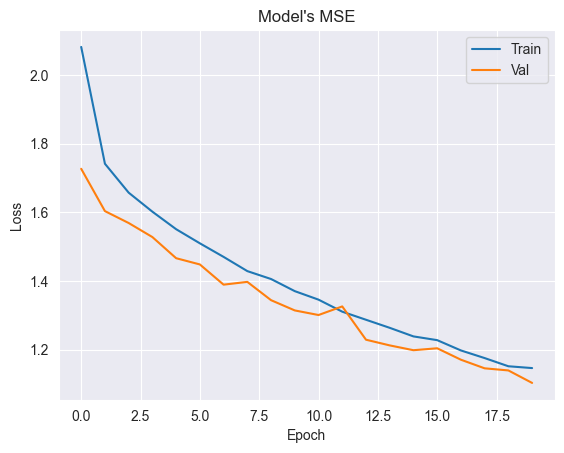

In [850]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's MSE")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Prediction

In [851]:
prediction_word = "också en kvinna"
prediction_word = tokenizer.texts_to_sequences([prediction_word])
prediction_word = pad_sequences(prediction_word, maxlen=input_dim)
prediction = model.predict([prediction_word])
output_probabilities = np.array(prediction)

result = []
class_labels = np.unique(y_pre_training)
for index, prediction in enumerate(output_probabilities[0]):
    result.append(f"{class_labels[index]} - {round(prediction*100, 1)}%")

for r in result:
    print(r)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Danish - 39.9%
Dutch - 3.4%
English - 9.8%
French - 0.7%
German - 3.7%
Greek - 0.0%
Italian - 0.6%
Norwegian - 27.0%
Polish - 1.0%
Portuguese - 0.3%
Russian - 0.0%
Spanish - 2.5%
Swedish - 10.9%


In [852]:
model.save('./model.keras')